In [1]:
from src.utils import interpolate_to_percentage
import matplotlib.pyplot as plt
import h5py
import numpy as np
np.set_printoptions(precision=3, suppress=True)
%matplotlib widget

import cv2
import mediapy

In [2]:
f = h5py.File("/home/jannik/Repos/demonstration-interface/data/session_20240626_124925_LAB_with_tracking/episode_20240626_124941.h5",'r')
poses = np.array(f['pose_values'])*1000
confidences = np.array(f['pose_confidences'])
color_images = np.array(f['color_images'])

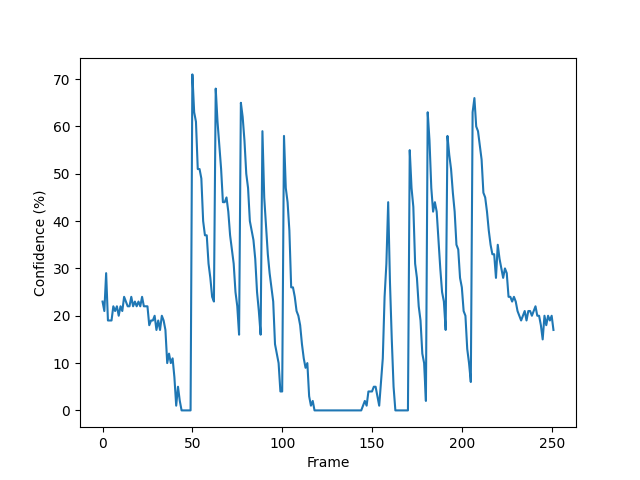

In [3]:
plt.figure()
plt.plot(confidences)
plt.xlabel('Frame')
plt.ylabel('Confidence (%)')
plt.show()

In [4]:
def fit_line_3d(points):
    # Center the data
    mean_point = points.mean(axis=0)
    centered_points = points - mean_point

    # Perform SVD
    _, _, vh = np.linalg.svd(centered_points)

    # The direction of the line is given by the first principal component
    line_direction = vh[0]

    # The point on the line can be the mean of the points
    line_point = mean_point

    return line_point, line_direction

def calculate_error(points, line_point, line_direction):
    # Normalize the direction vector
    line_direction = line_direction / np.linalg.norm(line_direction)

    # Calculate the projection of each point onto the line
    projections = line_point + np.dot(points - line_point, line_direction)[:, np.newaxis] * line_direction

    # Calculate the distance from each point to its projection
    distances = np.linalg.norm(points - projections, axis=1)

    # Calculate total error and mean squared error
    total_error = np.sum(distances)
    mean_squared_error = np.mean(distances ** 2)

    return distances, total_error, mean_squared_error


In [5]:
line_point, line_direction = fit_line_3d(poses[:,:3,3])

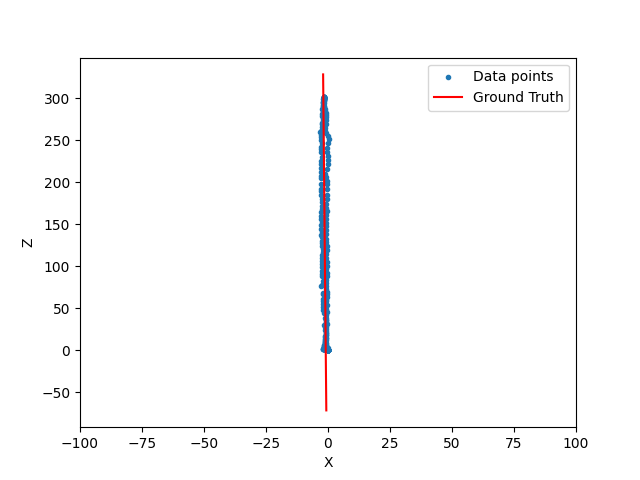

In [6]:
fig, ax = plt.subplots()
ax.scatter(poses[:, 0,3], poses[:, 2,3], label='Data points', marker=".")

t = np.linspace(-200, 200, 100)
line = line_point + t[:, np.newaxis] * line_direction

ax.plot(line[:, 0], line[:, 2], color='red', label='Ground Truth')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xlim(-100, 100)
ax.legend()
plt.show()

In [7]:
distances, total_error, mean_squared_error = calculate_error(poses[:,:3,3], line_point, line_direction)

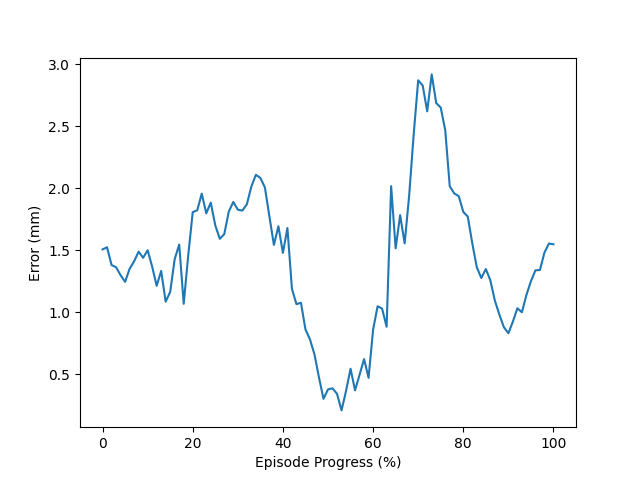

In [8]:
plt.figure()
plt.plot(interpolate_to_percentage(distances))
plt.xlabel('Episode Progress (%)')
plt.ylabel('Error (mm)')
plt.show()